##**Mounting Google Drive and Importing Libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing
import tensorflow as tf
import cv2
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
data_dir = '/content/drive/MyDrive/DerinOgrenme/RetinalImaging/Eyes/'

data_path = "/content/drive/MyDrive/DerinOgrenme/RetinalImaging/Eyes/"
cataract_path = os.path.join(data_path, "Cataract")
diabetic_path = os.path.join(data_path, "Diabetic Retinopathy")
glaucoma_path = os.path.join(data_path, "Glaucoma")
normal_path = os.path.join(data_path, "Normal")

print(os.listdir("/content/drive/MyDrive/DerinOgrenme/RetinalImaging/Eyes/"))

['Glaucoma', 'Normal', 'Cataract', 'Diabetic Retinopathy']


#**Data Analysis**

In [3]:
normals = os.listdir(normal_path)
cataracts = os.listdir(cataract_path)
diabetics = os.listdir(diabetic_path)
glaucomas = os.listdir(glaucoma_path)
print('Total number of normal images:',len(normals))
print('Total number of cataract images:',len(cataracts))
print('Total number of diabetic retinopathy images:',len(diabetics))
print('Total number of glaucoma images:',len(glaucomas))

Total number of normal images: 1074
Total number of cataract images: 1038
Total number of diabetic retinopathy images: 1098
Total number of glaucoma images: 1007


In [4]:
eye_normal = [normal for normal in normals]
eye_cataract = [cataract for cataract in cataracts]
eye_diabetic = [diabetic for diabetic in diabetics]
eye_glaucoma = [glaucoma for glaucoma in glaucomas]

Image 2829_right.jpg is normal eye X-Ray.


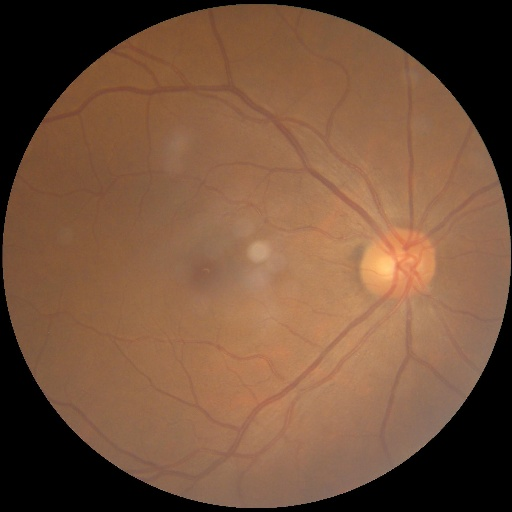

Image _120_2375814.jpg is cataract eye X-Ray.


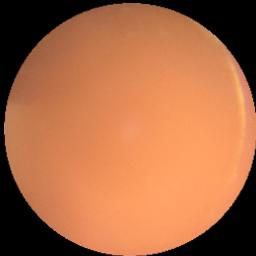

Image 11187_left.jpeg is diabetic retinopathy eye X-Ray.


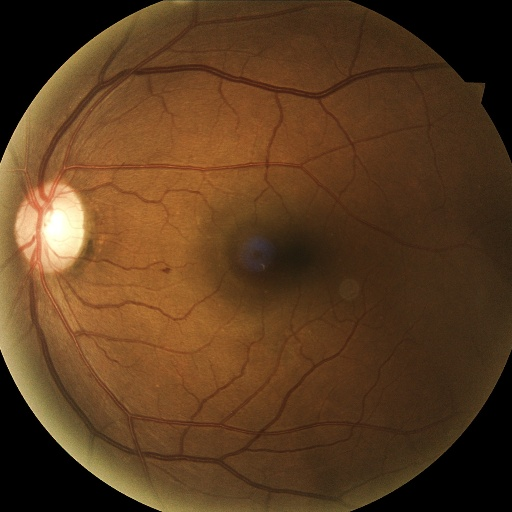

Image _323_8497084.jpg is glaucoma eye X-Ray.


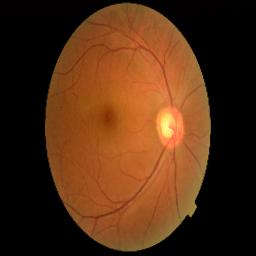

In [5]:
from IPython.display import Image
normal_image = np.random.choice(eye_normal,1)
cataract_image = np.random.choice(eye_cataract,1)
diabetic_image = np.random.choice(eye_diabetic,1)
glaucoma_image = np.random.choice(eye_glaucoma,1)

print("Image %s is normal eye X-Ray." % normal_image[0])
display(Image(os.path.join(data_path, "Normal",normal_image[0]),width=256,height=256))

print("Image %s is cataract eye X-Ray." % cataract_image[0])
display(Image(os.path.join(data_path, "Cataract",cataract_image[0]),width=256,height=256))

print("Image %s is diabetic retinopathy eye X-Ray." % diabetic_image[0])
display(Image(os.path.join(data_path, "Diabetic Retinopathy",diabetic_image[0]),width=256,height=256))

print("Image %s is glaucoma eye X-Ray." % glaucoma_image[0])
display(Image(os.path.join(data_path, "Glaucoma",glaucoma_image[0]),width=256,height=256))

##**Feature Extraction**

###Use pretrained ResNet model for feature extraction

In [6]:
from tensorflow.keras.preprocessing import image

# ResNet model
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False
    )

model = tf.keras.models.Model(
    inputs=base_model.input,
    outputs=base_model.output
    )

# Add image paths and tags to the list
image_paths = []
labels = []

for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image_paths.append(image_path)
        labels.append(class_name)

# Add data to a data frame
data_df = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Resume feature extraction
feature_vectors = []
for img_path in data_df['image_path']:
    img = image.load_img(img_path, target_size=(50, 50))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet.preprocess_input(img_array)
    features = model.predict(img_array)
    feature_vectors.append(features.flatten())

# Add feature vectors to a data frame
feature_df = pd.DataFrame(feature_vectors)
data_df = pd.concat([data_df, feature_df], axis=1)

1/1 [==============================] - 0s 23ms/step


In [7]:
# Display results
print(data_df.head())

                                          image_path     label         0  \
0  /content/drive/MyDrive/DerinOgrenme/RetinalIma...  Glaucoma  0.076311   
1  /content/drive/MyDrive/DerinOgrenme/RetinalIma...  Glaucoma  0.000000   
2  /content/drive/MyDrive/DerinOgrenme/RetinalIma...  Glaucoma  0.000000   
3  /content/drive/MyDrive/DerinOgrenme/RetinalIma...  Glaucoma  0.000000   
4  /content/drive/MyDrive/DerinOgrenme/RetinalIma...  Glaucoma  0.000000   

          1         2    3         4         5         6        7  ...  \
0  0.444144  1.297776  0.0  0.554006  0.000000  4.455937  0.00000  ...   
1  1.647306  1.419735  0.0  1.160902  0.000000  5.249978  0.00000  ...   
2  0.000000  0.000000  0.0  0.000000  0.908416  1.600498  0.00000  ...   
3  0.000000  3.018483  0.0  0.024449  0.000000  2.397582  0.48415  ...   
4  2.490806  0.000000  0.0  0.000000  0.000000  0.871590  0.00000  ...   

       8182  8183      8184      8185      8186  8187  8188      8189  \
0  0.865217   0.0  0.0000

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                          

##Classification with SVM

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Separating data into feature vectors and labels
X = data_df.drop(['image_path', 'label'], axis=1)
y = data_df['label']

In [10]:
# Separation into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Create and train an SVM model
svm_model = SVC(kernel='linear', C=1.0, probability=True)
svm_model.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [16]:
# Evaluation of the model
y_pred = svm_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8364928909952607

Classification Report:
                       precision    recall  f1-score   support

            Cataract       0.84      0.88      0.86       198
Diabetic Retinopathy       0.95      0.96      0.96       203
            Glaucoma       0.81      0.73      0.77       226
              Normal       0.75      0.79      0.77       217

            accuracy                           0.84       844
           macro avg       0.84      0.84      0.84       844
        weighted avg       0.84      0.84      0.84       844



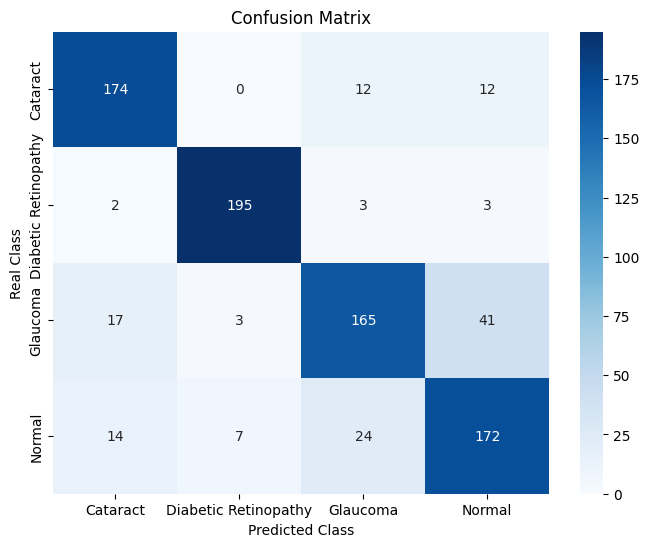

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix creation
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.title('Confusion Matrix')
plt.show()